In [ ]:
#!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
# !wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
# !tar xf ucf101_top5.tar.gz

In [ ]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from keras.layers import Layer
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

ModuleNotFoundError: ignored

In [ ]:
IMG_SIZE = 64
BATCH_SIZE = 8
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = (IMG_SIZE**2)*3

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
              temp_frame_features[i, j, :] = batch[None,j,:].reshape(-1)
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

In [ ]:
class ElementWiseAttention(tf.keras.layers.Layer):
    def __init__(self,input_shape):
        super(ElementWiseAttention, self).__init__()

        # f(att)
        self.sigmoid = tf.keras.layers.Conv1D(input_shape, 
                                            kernel_size=1, 
                                            strides=1, padding='same',
                                            use_bias=True, activation=tf.nn.sigmoid)
        
       

    def call(self, inputs):
        # f(att)
        a = self.conv0(inputs)
        a = self.conv1(a)
        a = self.conv2(a)
        
        # confidence score
        s = self.linear(inputs)

        # element-wise multiply to prevent unnecessary attention 
        m = s * a
        # using to minimize with weighted cross entorpy loss
        y_hat = self.gap(m)
        # could also using sigmoid like in paper
        out = self.sfm(y_hat)

        return m, out


In [ ]:
# Add attention layer to the deep learning network
class GRUCell_with_EleAttG(Layer):
    def __init__(self,**kwargs):
        self.EleAttG = ElementWiseAttention()
        self.GRUCell = tf.keras.layers.GRUCell() 
        super(GRUCell_with_EleAttG,self).__init__(**kwargs)
 
    def build(self,input_shape):      
        super(GRUCell_with_EleAttG, self).build(input_shape)
 
    def call(self,x):
        x = self.EleAttG(x)
        x = self.GRUCell(x)
        return x

In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.RNN(GRUCell_with_EleAttG(),return_sequences=True,return_state=True)(frame_features_input)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 1.5357 - accuracy: 0.2795
Epoch 1: val_loss improved from inf to 2.05032, saving model to /tmp/video_classifier
13/13 [==============================] - 12s 358ms/step - loss: 1.5357 - accuracy: 0.2795 - val_loss: 2.0503 - val_accuracy: 0.0000e+00
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 1.5013 - accuracy: 0.2699
Epoch 2: val_loss did not improve from 2.05032
13/13 [==============================] - 2s 136ms/step - loss: 1.5013 - accuracy: 0.2699 - val_loss: 2.1352 - val_accuracy: 0.0000e+00
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 1.4869 - accuracy: 0.3036
Epoch 3: val_loss did not improve from 2.05032
13/13 [==============================] - 2s 139ms/step - loss: 1.4869 - accuracy: 0.3036 - val_loss: 2.2036 - val_accuracy: 0.0000e+00
Epoch 4/10
13/13 [==============================] - ETA: 0s - loss: 1.4800 - accuracy: 0.2867
Epoch 4: val_loss did not improve from

Test video path: v_PlayingCello_g05_c06.avi
  CricketShot: 38.01%
  PlayingCello: 23.31%
  Punch: 22.90%
  TennisSwing:  8.12%
  ShavingBeard:  7.65%



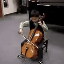

In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = batch[None, j, :].reshape(-1)
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])